# Fitting to time tag data natively

This notebook is intended to give an example of how to fit an estimated photon arrival rate to time tags (without binning).  

This notebook uses simulated data which.  To generate this data, you will need a function in the repo

    NCAR/deadtime-sim-ptv
    
This notebook utilizes PyTorch to perform the fitting routine.

Our aim is to obtain an estimate of $\lambda(t)$, the photon arrival rate, as a function of time $t$ (relative to laser pulse firing).  We obtain this using a list of $N$ time tags where photons arrived $\mathbf{t} =  \lbrace t_n \rbrace_{n=1}^N$.

For a Poisson point process the probability that the random photon arrivals $\mathbf{T}$ correspond the observations is

$\mathbb{P}\left( \lbrace T_n = t_n \rbrace_{n=1}^N \right) = e^{-\Lambda(t_{max})}\prod_{n=1}^{N} \lambda(t_n)$

where

$\Lambda(t) = \int_0^{t} \lambda(t') dt'$

and $t_{max}$ is the maximum time in the retrieval.

The above probability accounts for one laser shot.  For multiple shots, the PDFs should be multiplied.  In that case, for $L$ laser shots we obtain

$\mathbb{P}\left( \lbrace T_n = t_n \rbrace_{n=1}^N \right) = e^{-L \Lambda(t_{max})}\prod_{n=1}^{N} \lambda(t_n)$

where the list of photons comprises all arrivals from all laser shots.

In order to perform a fit, we aim to minimize the negative log-likelihood of the PDF.  This gives the loss function

$\mathcal{L}[\lambda(t)] = L \Lambda(t_{max}) - \sum_{n=1}^{N} \ln\lambda(t_n)$

From the above definition, it becomes clear that it is useful to have basis functions for $\lambda(t)$ that can be integrated analytically.  For this example, we use a Gaussian target in a constant background

$\lambda(t) = A \exp\left( -\frac{(t-\mu)^2}{2\sigma^2}\right) + b$

where the parameters $A$, $\mu$, $\sigma$ and $b$ must be estimated in the fitting routine.  The integral of the above arrival rate basis function is

$\Lambda(t) = \frac{1}{2} A \sigma \sqrt{2\pi} \left[1 + erf\left(\frac{t-\mu}{\sigma\sqrt{2}}\right)\right] + b t$

where $erf$ is the Gauss Error Function.

In [1]:
import os,sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import xarray as xr
import datetime

In [2]:
dtype = torch.float64
device = torch.device("cpu")

In [3]:
# import library for simulating Poisson point processes
dirP_str = os.path.join(os.environ['HOME'], 
                    'Documents',
                    'GitHub',
                    'deadtime-sim-ptv',
                    'python',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
    
import sim_deadtime_utils as sim

# Generate Simulated Data

In [137]:
# simulation resolution settings
t_sim_min = 0
t_sim_max = 1e-6
dt_sim = 1e-12

tD = 200e-9 # deadtime
Nshot = 100 # number of laser shots
wrap_deadtime = True  # wrap deadtime between shots

laser_pulse_width = 60e-9 # laser pulse width in seconds
target_time = 700e-9
target_amplitude = 5e6 # target peak count rate
background = 1e5  # background count rate

In [138]:
# generate the simulated scene time axis
t_sim = np.arange(t_sim_min,t_sim_max,dt_sim)           # simulation time
t_sim_bins = np.concatenate((t_sim,t_sim[-1:]+dt_sim))  # simulation time histogram bins

In [139]:
# generate the photon arrival rate of the profile
# Gaussian target with constant background
photon_rate_arr = target_amplitude*np.exp(-(t_sim - target_time)**2/(2*laser_pulse_width**2))+background

In [182]:
# define vars for saving data
data_date_str = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
save_data_path = os.path.join(os.environ['HOME'],'Documents/MPD/DataForMLEPaper/')

In [140]:
# generate photon counts

# lists of photon arrivals per
# laser shot
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = [] # actual photons (no dead time)

t_det_last = -100.0  # last photon detection event
for n in range(Nshot):
    # simulate a laser shot
    ptime,ctime = sim.photon_count_generator(t_sim_bins, 
                                            photon_rate_arr, 
                                            tau_d_flt=tD,
                                            last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]
        
    t_det_lst += [ctime]  # detection time tags (including deadtime)
    t_phot_lst += [ptime] # photon time tags

Text(0.5, 1.0, 'Detected Photons')

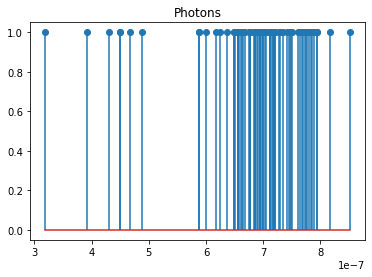

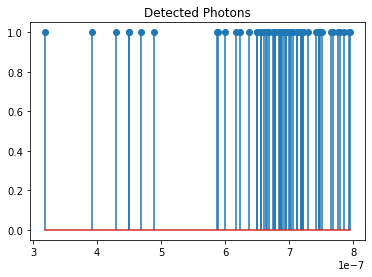

In [141]:
phot_arr = np.array(sorted(np.concatenate(t_phot_lst)))
plt.figure()
plt.stem(phot_arr,np.ones(phot_arr.size))
plt.title('Photons')


cnt_arr = np.array(sorted(np.concatenate(t_det_lst)))
plt.figure()
plt.stem(cnt_arr,np.ones(cnt_arr.size))
plt.title('Detected Photons')

Text(0, 0.5, 'Arrival Rate [MHz]')

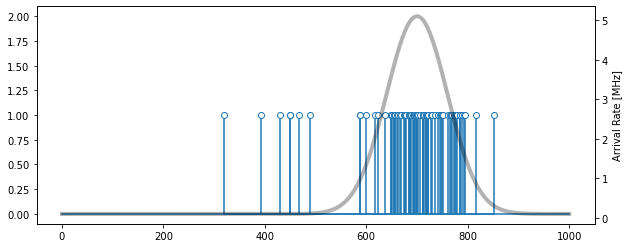

In [142]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
(markers, stemlines, baseline) = ax.stem(1e9*phot_arr,np.ones(phot_arr.shape),markerfmt='w',basefmt='C0')
plt.setp(markers, marker='o', markersize=6, markeredgecolor="C0", markeredgewidth=1)
ax.plot([t_sim.min()*1e9,t_sim.max()*1e9],[0,0],'C0')
ax.plot([t_sim.min()*1e9,t_sim.max()*1e9],[2,2],'w')

ax2 = ax.twinx()
ax2.plot(1e9*t_sim,1e-6*photon_rate_arr,label='Actual',color='k',alpha=0.3,linewidth=4)
ax2.set_ylabel("Arrival Rate [MHz]")

In [143]:
# split data into fit and validation sets
# since we are assuming a fixed target between shots
# we can just split the data in chunks.
split_index = int(len(t_phot_lst)//2)
cnt_phot_fit = len(t_phot_lst[:split_index])
cnt_phot_val = len(t_phot_lst[split_index:])
t_phot_fit = np.concatenate(t_phot_lst[:split_index])
t_phot_val = np.concatenate(t_phot_lst[split_index:])

Double check the integral approximation using erf()

In [144]:
t_torch = torch.tensor(t_sim)
integral_est = torch.tensor(t_sim*background) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi)\
            *torch.special.erf((t_torch-target_time)/(laser_pulse_width*np.sqrt(2)))

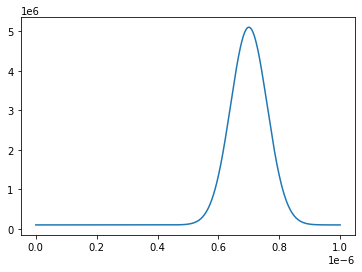

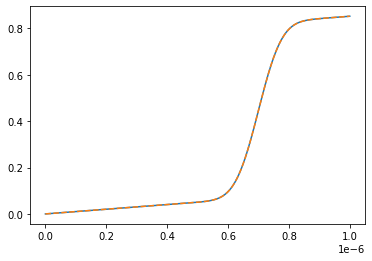

In [145]:
plt.figure()
plt.plot(t_sim,photon_rate_arr)

plt.figure()
plt.plot(t_sim,np.cumsum(photon_rate_arr)*dt_sim)
plt.plot(t_sim,integral_est.numpy(),'--')

# Perform Fit Using PyTorch
Assume the target is described by a Gaussian with a constant background

In [146]:
# convert training and validation data to 
# tensor type
t_phot_fit_tnsr = torch.tensor(t_phot_fit)
t_phot_val_tnsr = torch.tensor(t_phot_val)

In [147]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(6*torch.ones(()))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-9*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-8*torch.ones(())) # Gaussian std
        self.log_b = torch.nn.Parameter(4*torch.ones(()))      # background
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
        b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = A*torch.exp(-(t-mu)**2/(2*sig**2)) + b
        
        # calculate the integral
        integral_out = b*self.t_max \
                        + 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2))
        
        return model_out, integral_out

In [148]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [149]:
# optimization parameters
rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [150]:
# initialize for fit loop
fit_model = Fit_Pulse(t_sim[-1])
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

In [151]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [152]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred,integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred,integral*cnt_phot_fit)  # add regularization here
    train_loss_lst +=[loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
    pred_val,integral_val = fit_model(t_phot_val_tnsr)
    loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
    valid_loss_lst +=[loss_val.item()]

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1

In [153]:
# calculate the validation loss.
# we would use this to determine optimimal tuning parameters
# if we had any (e.g. more Gaussian targets)
pred_val,integral_val = fit_model(t_phot_val_tnsr)
loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
print(f"Validation Loss: {loss_val}")

Validation Loss: -520.4147559526867


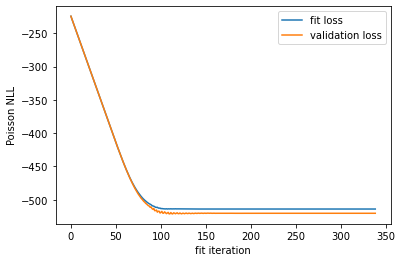

In [154]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

Display the resulting estimate

In [155]:
pred_mod_full,integral_full = fit_model(torch.tensor(t_sim))

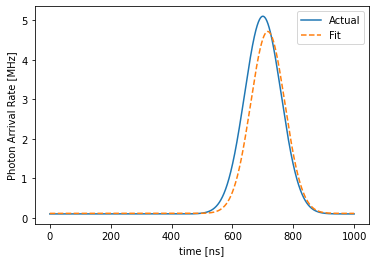

In [156]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_sim*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

In [197]:
init_model = Fit_Pulse(t_sim[-1])
init_mod_full,init_integral_full = init_model(torch.tensor(t_sim))

(400.0, 1000.0)

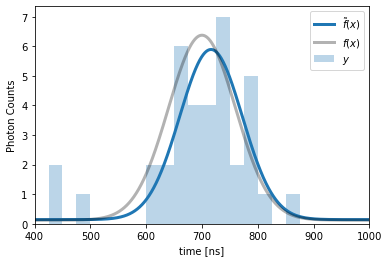

In [193]:
h_phot = np.histogram(t_phot_fit,bins=np.linspace(0,1000e-9,41))
dh_bins = np.median(np.diff(h_phot[1]))
plt.figure()
plt.bar(1e9*h_phot[1][:-1],h_phot[0],label='$y$',align='edge',width=1e9*np.diff(h_phot[1]),alpha=0.3)
plt.plot(t_sim*1e9,0.5*pred_mod_full.detach().numpy()*dh_bins*Nshot,'-',label=r'$\tilde{f}(x)$',linewidth=3) # /cnt_phot_fit
plt.plot(t_sim*1e9,0.5*photon_rate_arr*dh_bins*Nshot,'-',label='$f(x)$',linewidth=3,color='k',alpha=0.3)
plt.xlabel('time [ns]')
plt.ylabel('Photon Counts')
plt.legend()
plt.xlim([400,1000])

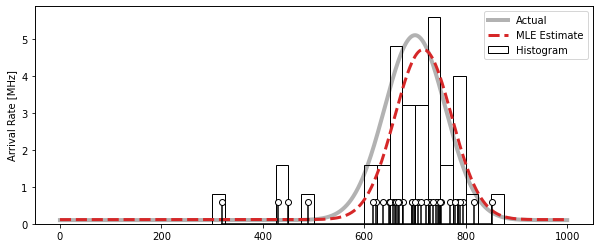

In [200]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax2 = ax.twinx()

stem_color_str = "k"
(markers, stemlines, baseline) = ax2.stem(1e9*t_phot_fit,np.ones(t_phot_fit.shape),markerfmt='none',basefmt=stem_color_str,bottom=0)
plt.setp(markers, marker='o', markersize=6, markeredgecolor=stem_color_str, markeredgewidth=1,markerfacecolor='w')
plt.setp(stemlines,color=stem_color_str)
# ax2.plot([t_sim.min()*1e9,t_sim.max()*1e9],[0,0],'C0')
# ax2.plot([t_sim.min()*1e9,t_sim.max()*1e9],[5,5],'w')
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylim([0,10])

ax.bar(1e9*h_phot[1][:-1],2e-6*h_phot[0]/dh_bins/Nshot,label='Histogram',
       align='edge',width=1e9*np.diff(h_phot[1]),
       facecolor='w',edgecolor='k',linewidth=1.0)

ax.plot(1e9*t_sim,1e-6*photon_rate_arr,label='Actual',color='k',alpha=0.3,linewidth=4)
ax.plot(t_sim*1e9,1e-6*pred_mod_full.detach().numpy(),'C3--',label=r'MLE Estimate',linewidth=3)
# ax.plot(t_sim*1e9,1e-6*init_mod_full.detach().numpy(),'C2:',label=r'Initial Estimate',linewidth=3)

ax.set_ylabel("Arrival Rate [MHz]")
ax.set_xlabel("Arrival Time [ns]")

ax.legend()

# plt.savefig(os.path.join(save_data_path,'Plot_Fit_Results_'+data_date_str+'.tif'),dpi=300)
# plt.savefig(os.path.join(save_data_path,'Plot_Fit_Results_'+data_date_str+'.png'),dpi=300)

In [201]:
ds = xr.Dataset({},attrs={'tD':tD,'Nshot':Nshot,'laser_pulse_width':laser_pulse_width,
                         'target_time':target_time,
                         'target_amplitude':target_amplitude,
                         'background':background,
                         'fit_target_amplitude':np.exp(fit_model.log_A.detach().numpy()),
                         'fit_target_time':np.exp(fit_model.log_mu.detach().numpy()),
                         'fit_laser_pulse_width':np.exp(fit_model.log_sig.detach().numpy()),
                         'fig_background':np.exp(fit_model.log_b.detach().numpy()),
                         'init_target_amplitude':np.exp(init_model.log_A.detach().numpy()),
                         'init_target_time':np.exp(init_model.log_mu.detach().numpy()),
                         'init_laser_pulse_width':np.exp(init_model.log_sig.detach().numpy()),
                         'init_background':np.exp(init_model.log_b.detach().numpy())
                         })

ds['t_phot_fit'] = xr.DataArray(t_phot_fit,dims=('t_phot_fit'),
                               attrs={
                                   'units':'s',
                                   'description':'photon arrival times for fit data'})
ds['t_phot_val'] = xr.DataArray(t_phot_val,dims=('t_phot_val'),
                               attrs={
                                   'units':'s',
                                   'description':'photon arrival times for validation data'})

ds['t_sim'] = xr.DataArray(t_sim,dims=('t_sim'),
                          attrs={
                              'units':'s',
                              'description':'time axis used for simulation and plotting fit data'
                          })

ds['photon_rate_arr'] = xr.DataArray(photon_rate_arr,dims=('t_sim'),
                                  coords={'t_sim':ds['t_sim']},
                                  attrs={
                                      'units':'Hz',
                                      'description':'True photon arrival rate used in simulation'
                                  })

ds['est_photon_rate_arr'] = xr.DataArray(pred_mod_full.detach().numpy(),dims=('t_sim'),
                                  coords={'t_sim':ds['t_sim']},
                                  attrs={
                                      'units':'Hz',
                                      'description':'Estimated photon arrival rate from fit data'
                                  })

In [202]:
print(f'mean: {np.mean(t_phot_fit)*1e9} ns')
print(f'std: {np.std(t_phot_fit)*1e9} ns')
print(f'std: {np.max(t_phot_fit)*1e9} ns')

mean: 686.1790940466157 ns
std: 107.71929925068727 ns
std: 851.3567755772532 ns


In [203]:
dh_bins

2.4999999999999986e-08

In [204]:
ds.to_netcdf(os.path.join(save_data_path,'Fit_Results_'+data_date_str+'.nc'))

In [205]:
ds.attrs

{'tD': 2e-07,
 'Nshot': 100,
 'laser_pulse_width': 6e-08,
 'target_time': 7e-07,
 'target_amplitude': 5000000.0,
 'background': 100000.0,
 'fit_target_amplitude': 4600707.0,
 'fit_target_time': 7.1617757e-07,
 'fit_laser_pulse_width': 5.6081987e-08,
 'fig_background': 113247.5,
 'init_target_amplitude': 403.42877,
 'init_target_time': 0.0001234098,
 'init_laser_pulse_width': 0.00033546262,
 'init_background': 54.59815}

In [548]:
# calculate the modeled values at each photon arrival
pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

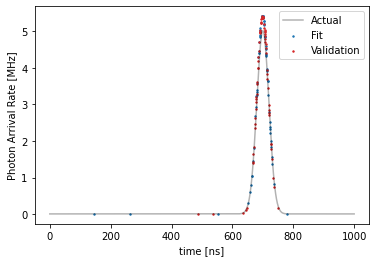

In [551]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,s=2,label='Fit')
plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,s=2,label='Validation',c='tab:red')
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

# Multi Gaussian Model

In [554]:
# convert training and validation data to 
# tensor type
t_phot_fit_tnsr = torch.tensor(t_phot_fit)
t_phot_val_tnsr = torch.tensor(t_phot_val)

In [555]:
# build the fit model as a NN module
class Fit_MultiPulse(torch.nn.Module):
    def __init__(self,t_max,num_gaus):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(5+torch.randn(num_gaus))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-9+torch.ones(num_gaus))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-9+torch.ones(num_gaus)) # Gaussian std
        self.log_b = torch.nn.Parameter(3+torch.randn(1))      # background
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)[None,:]
        mu = torch.exp(self.log_mu)[None,:]
        sig = torch.exp(self.log_sig)[None,:]
        b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = torch.sum(A*torch.exp(-(t[:,None]-mu)**2/(2*sig**2)),dim=1) + b
        
        # calculate the integral
        integral_out = b*self.t_max \
                        + torch.sum(0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2)),dim=1)
        
        return model_out, integral_out

In [556]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [557]:
# optimization parameters
rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [558]:
# initialize for fit loop
fit_model = Fit_MultiPulse(t_sim[-1],3)
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

In [559]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [560]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred,integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred,integral*cnt_phot_fit)  # add regularization here
    train_loss_lst +=[loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
    pred_val,integral_val = fit_model(t_phot_val_tnsr)
    loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
    valid_loss_lst +=[loss_val.item()]

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1

In [561]:
# calculate the validation loss.
# we would use this to determine optimimal tuning parameters
# if we had any (e.g. more Gaussian targets)
pred_val,integral_val = fit_model(t_phot_val_tnsr)
loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
print(f"Validation Loss: {loss_val}")

Validation Loss: tensor([-962.2623], grad_fn=<SubBackward0>)


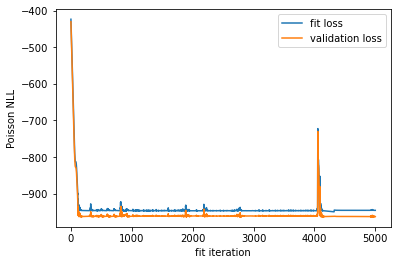

In [562]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

Display the resulting estimate

In [563]:
pred_mod_full,integral_full = fit_model(torch.tensor(t_sim))

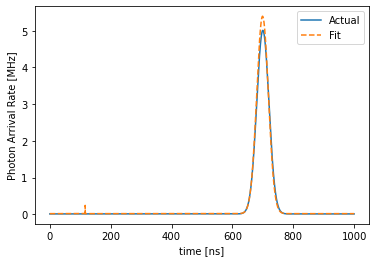

In [564]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_sim*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

In [565]:
# calculate the modeled values at each photon arrival
pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

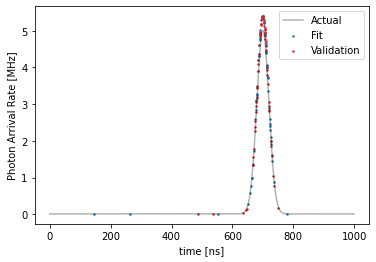

In [566]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,s=2,label='Fit')
plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,s=2,label='Validation',c='tab:red')
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

## Optimize number of Gaussians

In [698]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [699]:
# optimization parameters
rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
repeat_count = 30     # number of times to repeat the initialization
max_mode_count = 10   # max number of Gaussian modes to evaluate

In [700]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [701]:
sol_lst = []
fit_lst = []
vld_lst = []
epoch_lst = []
num_gaus_lst = []

In [702]:
for num_gaussian in range(1,max_mode_count):
    for init_cnt in range(repeat_count):
        # initialize for fit loop
        fit_model = Fit_MultiPulse(t_sim[-1],num_gaussian)
        optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
        epoch=0
        rel_step = 1e3*rel_step_lim
        train_loss_lst = []
        valid_loss_lst = []
        rel_step_lst = []

        # perform fit
        while rel_step > rel_step_lim and epoch < max_epochs:
            fit_model.train()
            pred,integral = fit_model(t_phot_fit_tnsr)
            loss = loss_fn(pred,integral*cnt_phot_fit)  # add regularization here
            train_loss_lst +=[loss.item()]

            # calculate relative step as an average over the last
            # term_persist iterations
            if epoch == 0:
                rel_step_lst+=[1e3*rel_step_lim]
                rel_step = 1e3*rel_step_lim
            else:
                rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
                rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

            # calculate validation loss... for fun
            pred_val,integral_val = fit_model(t_phot_val_tnsr)
            loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
            valid_loss_lst +=[loss_val.item()]

            # update estimated parameters
            loss.backward()
            optimizer.step()

            # zero out the gradient for the next step
            optimizer.zero_grad()

        #     print(f"{train_loss_lst[-1]}")

            epoch+=1

        # calculate the validation loss.
        # we would use this to determine optimimal tuning parameters
        # if we had any (e.g. more Gaussian targets)
        pred_val,integral_val = fit_model(t_phot_val_tnsr)
        loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
#         print(f"{num_gaussian} modes, Validation Loss: {loss_val.item()}")

        pred_mod_full,integral_full = fit_model(torch.tensor(t_sim))

        sol_lst.append(fit_model.parameters())
        fit_lst.append(pred_mod_full)
        vld_lst.append(loss_val.item())
        num_gaus_lst.append(num_gaussian)
        epoch_lst.append(epoch)
    print(f"{num_gaussian} modes")

1 modes
2 modes
3 modes
4 modes
5 modes
6 modes
7 modes
8 modes
9 modes


In [703]:
isol = np.argmin(vld_lst)

In [704]:
vld_arr = np.array(vld_lst).reshape(-1,repeat_count)
num_gaus_arr = np.array(num_gaus_lst).reshape(-1,repeat_count,)

Text(0, 0.5, 'Validation NLL')

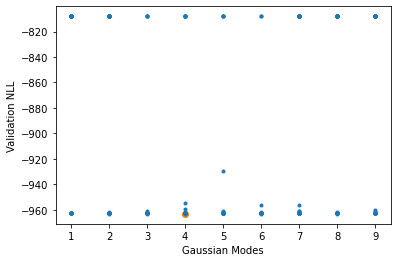

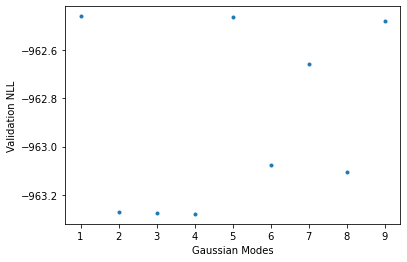

In [705]:
plt.figure()
plt.plot(num_gaus_lst[isol],vld_lst[isol],'o',color='tab:orange')
plt.plot(num_gaus_lst,vld_lst,'.',color='tab:blue')
plt.xlabel("Gaussian Modes")
plt.ylabel("Validation NLL")


plt.figure()
# plt.plot(num_gaus_lst[isol],vld_lst[isol],'o',color='tab:orange')
plt.plot(np.mean(num_gaus_arr,axis=1),np.min(vld_arr,axis=1),'.',color='tab:blue')
plt.xlabel("Gaussian Modes")
plt.ylabel("Validation NLL")



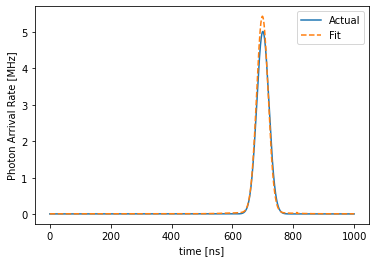

In [706]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_sim*1e9,fit_lst[isol].detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

In [707]:
for param in sol_lst[isol]:
    print(param)

Parameter containing:
tensor([10.1906, 15.4976, 13.1262, 10.5598], requires_grad=True)
Parameter containing:
tensor([-14.0238, -14.1743, -12.9632, -14.1937], requires_grad=True)
Parameter containing:
tensor([-23.8347, -17.7832, -19.9467, -16.3025], requires_grad=True)
Parameter containing:
tensor([9.4755], requires_grad=True)


In [639]:
# epoch_lst